# Bayesian A/B Testing

F. Burkholder, adapted from T. Heilman's and R. Henning's notebooks.

**Objectives:**

- Review Hypothesis Testing
- Compare and Contrast Frequentist vs Bayesian Mindsets
- Perform A/B Testing under a Bayesian Framework
- Explain what a conjugate prior is
- Show why Bayesian A/B Testing is _Bayesian_

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
# control the size of the font
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

## Review of Frequentist Hypothesis Testing

Steps:

1. Define your null hypothesis.
2. Define the alpha (significance) cutoff.
3. Determine how many samples you'll need for a given effect size and significance level (the power).
3. Collect data.
4. Compute the appropriate statistic (e.g. the t-statistic).
5. Compute the probability of that statistic (or something more rare) under the null hypothesis. (aka, the p-value)
6. "Reject" or "fail to reject" the null hypothesis.

For example,

Say our company goal is to have our website generate new users with a conversion rate of 10%. Let's do a hypothesis test to see if we are hitting our goal.

**Step 1:**

Define the null hypothesis as "the conversion rate is 10%", i.e. $\mu = 0.1$  Alternate, "the conversion rate is not 10%" $\mu \ne 0.1$

In [3]:
null_hypot_mu = 0.1

**Step 2:**

Define the significance level (alpha cutoff). We'll use the typical 5% type-I error rate, and choose a two-tailed test.

In [4]:
alpha_cutoff = 0.05

**Step 3:**

The data is a series of bernoulli trials (a binomial distribution)- either a person converts or they don't.  The Null hypothesis is the proportion that convert, p, is 0.1, of 1 in 10.  

Need a power calculation for 2-sided one-sample binomial test.

Oh look.  [Here](http://powerandsamplesize.com/Calculators/Other/1-Sample-Binomial) is a one-sample binomial test power calculator.  Let's use it with an effect size of 1% (0.01).

In [5]:
# from the calculator
n = 7670

**Step 4:**

Collect data. Here it is:

In [6]:
samples = 1*(np.random.random(n)>1 - .11)
print('A few results: ', samples)
print('Conversions: ',samples.sum())
print('Non-conversions: ', len(samples)-samples.sum())
print('Conversion rate: ', samples.mean())

A few results:  [0 0 0 ... 1 1 0]
Conversions:  828
Non-conversions:  6842
Conversion rate:  0.10795306388526728


**Step 5 and 6:**  
 

The [binomial test](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.binom_test.html) tests whether a proportion (such as the mean number of clicks) is equal to some value.  

In [7]:
from scipy.stats import binom_test

successes = samples.sum()
trials = len(samples)

p_value = stats.binom_test(successes, trials, null_hypot_mu)

print('p value: ', p_value)

p value:  0.021279925448830495


**Step 6:**

In [8]:
if p_value < alpha_cutoff:
    print("REJECT null hypothesis! (i.e. this data is unusual enough under the null that we reject the null)")
else:
    print("FAIL TO REJECT null hypothesis (i.e. not enough evidence to reject)")

REJECT null hypothesis! (i.e. this data is unusual enough under the null that we reject the null)


## The Frequentist Mindset vs The Bayesian Mindset

### What's in a Frequentist?

A frequentist subscribes to what is now called "classical statistics". Frequentists define _probability_ as:

Probability:
------------
>The relative frequency of occurrence of an experiment's outcome as the number of trials
approaches infinity. This is usually referred to as the "long run" frequency of an event.


i.e.

$$P(x) = \lim_{n_t \to \infty} \dfrac{n_x}{n_t}$$

where $n_t$ is the number of trials and $n_x$ is the number of trials where the outcome is $x$.

**Most importantly:** Frequentists do hypothesis testing and talk about p-values.

Read more [here](https://en.wikipedia.org/wiki/Probability#Interpretations) and [here](https://en.wikipedia.org/wiki/Frequentist_probability).

### The Bayesian Way

"Probability is what you _believe_."


Sound subjective? ... Well, it is! Bayesians agree, to some extent. More on that later.

**The Bayesian way** is to start with a belief, then update your belief as you see evidence. Then update your belief again as you see more evidence. Etc.

For example (using my beliefs):

$$
\begin{align*}
&P(\text{it rained last night}) = 0.15 \\
&P(\text{it rained last night} \, \, | \, \, \text{I am in Seattle}) = 0.8 \\
&P(\text{it rained last night} \, \, | \, \, \text{I am in Seattle and the ground is wet}) = 0.95
\end{align*}
$$

Read more [here](https://en.wikipedia.org/wiki/Probability#Interpretations) and [here](https://en.wikipedia.org/wiki/Bayesian_probability).

### Conclusion: Frequentists vs Bayesian

**Frequentist** care about "long run" probabilities. Everything they do is with this "long run" mindset. E.g. p-values answer the question: "Under the null hypothesis, how often would I see this data (or something more rare) if I sampled from the population over-and-over-and-over... forever."

**Bayesians** care about their "beliefs", and quantify them in their prior. Sometimes they are certain about their beliefs, and sometimes their beliefs are vague. Either way, they update their beliefs whenever they see more evidence (i.e. data).

**When data are limited, the Bayesian approach has obvious utility (but will the relative lack of data just confirm your prior belief?!)**

## Let's do Bayesian A/B Testing

So, we know how to run hypothesis tests (from the frequentist world), and we can do A/B testing via hypothesis testing, of course.

But now let's do A/B testing under a Bayesian framework.

First, we need to learn about a new distribution, the **Beta Distribution**.

### The Beta Distribution: $\text{Beta}(\alpha, \beta)$

The beta distribution has two hyper-parameters (also known as "shape parameters"):
- $\alpha > 0$: we will use this to encode the number of "successes" of a website (more on that later)
- $\beta > 0$: we will use this to encode the number of "failures" of a website (more on that later)

Support: $x \in [0, 1]$

PDF: $f(x) = \dfrac{x^{\alpha - 1} (1-x)^{\beta - 1}}{B(\alpha, \beta)}$

where $B(\alpha, \beta) = \dfrac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}$

where $\Gamma(x)$ is an extension of the factorial function which works for a wider range of input (like any positive real value, which is why it works here).

**Get a feel for the Beta Distribution:**

Let's plot a few Beta Distributions (with varying shape parameters). Notice the support of each distribution is $x \in [0, 1]$.

In [9]:
def plot_beta(alpha, beta, ax, title=None, label=None, xticks=[0.0, 0.5, 1.0]):

    # Build a beta distribtuion scipy object.
    dist = stats.beta(alpha, beta)

    # The support (always this for the beta dist).
    x = np.linspace(0.0, 1.0, 201)

    # The probability density at each sample support value.
    y = dist.pdf(x)

    # Plot it all.
    lines = ax.plot(x, y, label=label)
    ax.fill_between(x, y, alpha=0.2, color=lines[0].get_c())
    if title: 
        ax.set_title(title)
    ax.get_yaxis().set_ticks([])
    #ax.get_yaxis().set_ticks([np.max(y)])
    ax.get_xaxis().set_ticks(xticks)
    ax.set_ylim(0.0, np.max(y)*1.2)

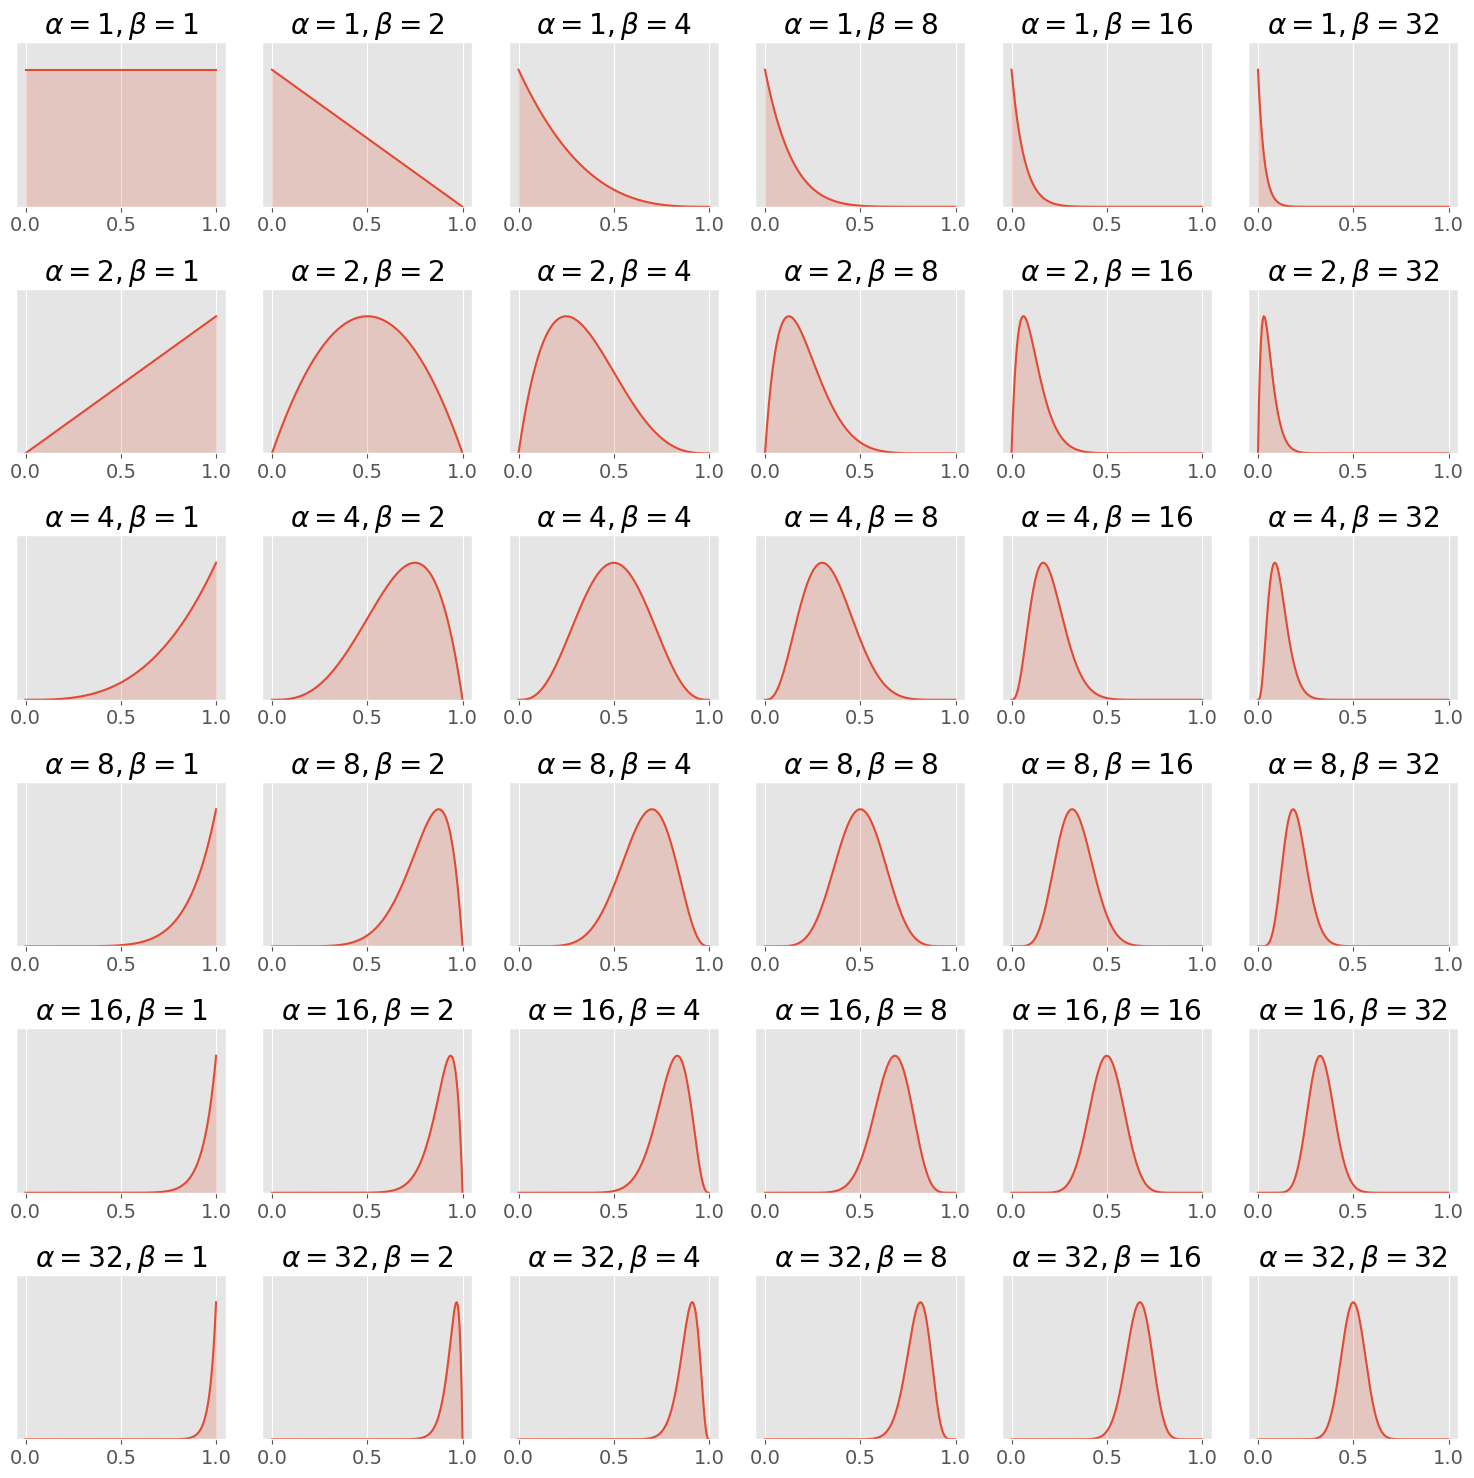

In [10]:
# The shape parameters.
alpha_values = [1, 2, 4, 8, 16, 32]  
beta_values  = [1, 2, 4, 8, 16, 32]
n_rows, n_cols = len(alpha_values), len(beta_values)
alpha_beta_pairs = ( (i, j) for i in alpha_values for j in beta_values )

# Create a large figure - nice way to do it.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

# Plot each beta dist. One plot per pair of shape params.
for (alpha, beta), ax in zip(alpha_beta_pairs, axes.flatten()):
    plot_beta(alpha, beta, ax, r"$\alpha={} ,  \beta={}$".format(alpha, beta))

plt.tight_layout()

**What patterns do you see in the above distributions?**

Here are a few:
 - If $\alpha$ is larger than $\beta$, the distribution leans to the **right**.
 - If $\alpha$ is smaller than $\beta$, the distribution leans to the **left**.
 - If $\alpha = \beta$, the distribution is **symmetric** and **centered** at $0.5$.
 - The distribution gets **skinnier** as $\alpha$ and $\beta$ increase.

Linking $\alpha$ and $\beta$ to the moments:

The **mean** of the Beta Distribution is: $E(X) = \dfrac{\alpha}{\alpha + \beta}$

The **variance** of the Beta Distribution is: $\text{Var}(X) = \dfrac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}$

### How we can use the Beta Distribution (A BIG IDEA)

What if we set:
- $\alpha = 1 + \text{number of conversions on our website}$
- $\beta = 1 + \text{number of misses on our website}$

Then, as we know, the **mean of the beta distribution** would be $\dfrac{\alpha}{\alpha + \beta}$ which equals smoothed **conversion rate**!

Also, the more visitors we have (i.e. the larger $(\alpha + \beta)$), then the **smaller the variance of our beta distribution will be**.

Also, don't forget that the support of the beta distribution is $x \in [0, 1]$ which is the same range for conversion rates (0% up to 100%).

Put all this together, the beta distribution models the probability of the conversion rate of our website (which we are trying to figure out from our data). The beta distribution is one way to model our **belief** of what the conversion rate might be.

A continuous probability distribution (like the beta distribution) puts relative likelihoods to each of the values in the support. In our case, the support is theorized conversion rates. On the y-axis of the PDF we have probability density, and on the x-axis of the PDF we have probabilities (conversion rates). So we have probabilities of probabilities (relative probability of conversion rates.)

**Why we like it:** The reason we like it is that this lets us know the **strength of our belief** about the conversion rate of our website. Check out the three plots below:

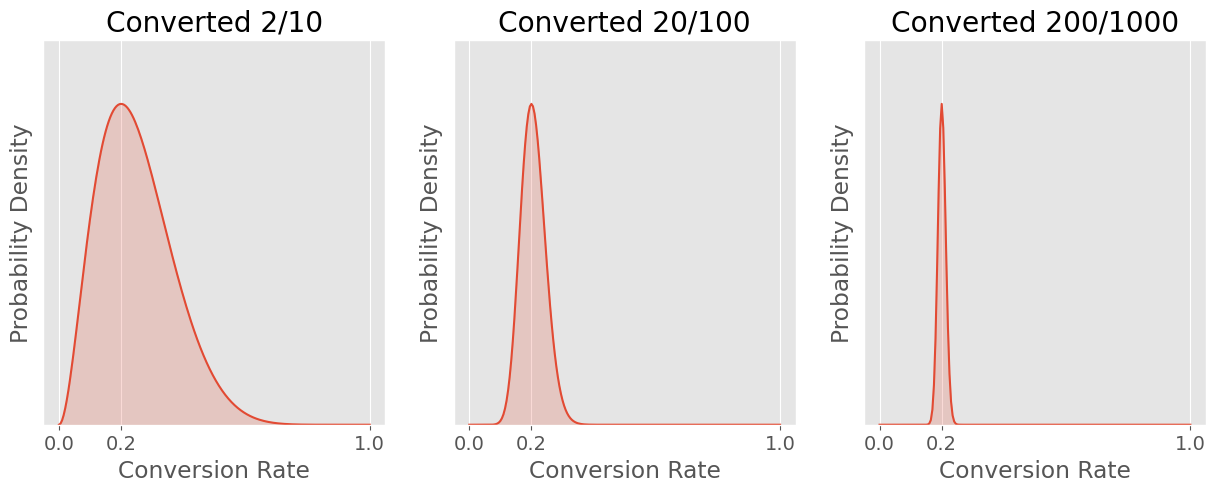

In [11]:
def get_beta_dist_params(website_samples):
    website_samples = np.array(website_samples)
    num_conversions = website_samples.sum()
    total_visitors = len(website_samples)
    alpha = num_conversions + 1
    beta = (total_visitors - num_conversions) + 1
    mean = 1 * num_conversions / total_visitors
    return alpha, beta, mean, num_conversions, total_visitors

def plot_beta_website(website_samples, ax, label=None):
    alpha, beta, mean, num_conversions, total_visitors = get_beta_dist_params(website_samples)
    title = None if label else r"Converted {}/{}".format(num_conversions, total_visitors)
    plot_beta(alpha, beta, ax, title, label, [0.0, mean, 1.0])
    ax.set_xlabel("Conversion Rate")
    ax.set_ylabel("Probability Density")

fig, (left, mid, right) = plt.subplots(1, 3, figsize=(15, 5))

plot_beta_website([0, 1, 0, 0, 0]*2, left)
plot_beta_website([0, 1, 0, 0, 0]*20, mid)
plot_beta_website([0, 1, 0, 0, 0]*200, right)

It is clear that we can use this distribution to model both (1) our belief of the conversion rate based on the data we have (i.e. via the mean), and (2) the strength of our belief (i.e. via the variance).

**A good Bayesian never claims to know anything exactly. Instead they have some beliefs, and they have various levels of strengths regarding their beliefs.**

## Bayesian A/B testing

We're finally ready to do the Bayesian A/B testing.

Say we have two versions of our website: version A and version B (version C we'll use later).

Let's read in the log of our historical visitors for both version A and version B.

A .npz file contains saved numpy arrays using [.savez](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.savez.html#numpy.savez).

In [12]:
x = np.load("samples.npz")

In [13]:
type(x)

numpy.lib.npyio.NpzFile

In [14]:
list(x.keys())

['site_B_samples', 'site_C_samples', 'site_A_samples']

In [15]:
# take a peek at the data
x['site_A_samples'][:20]

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0],
      dtype=int64)

In [16]:
# how many total?
print("Shape A: ", x['site_A_samples'].shape)
print("Shape B: ", x['site_B_samples'].shape)

Shape A:  (10000,)
Shape B:  (10000,)


In [17]:
# load in a subset

site_A_samples = x['site_A_samples'][:1000]
site_B_samples = x['site_B_samples'][:1000]

np.mean(site_A_samples), np.mean(site_B_samples)

(0.202, 0.225)

Now let's plot our belief about each site's conversion rate.

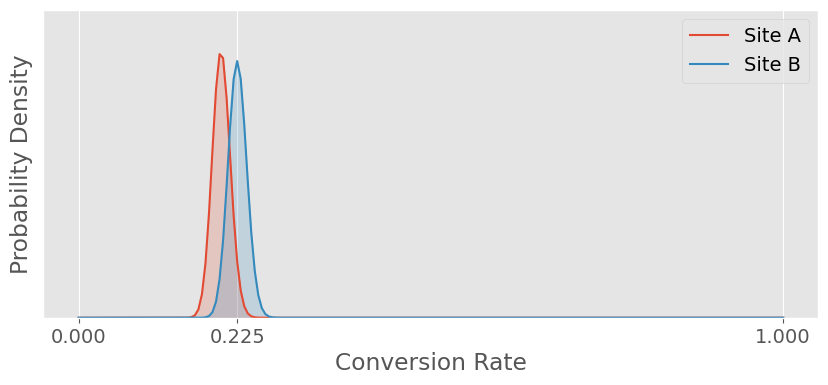

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plot_beta_website(site_A_samples, ax, label="Site A")
plot_beta_website(site_B_samples, ax, label="Site B")
ax.legend()

### Important question: What's the probability that site B is better than site  A?
Let's figure out how much of site B's Beta distribution is to the right of site A's. We can't do that algebraically, but we can estimate it through simulation! And the code is short and easy:

In [19]:
num_simulations = 100000

alpha, beta = get_beta_dist_params(site_A_samples)[:2]
dist_A = stats.beta(alpha, beta)

alpha, beta = get_beta_dist_params(site_B_samples)[:2]
dist_B = stats.beta(alpha, beta)

simulated_A = dist_A.rvs(num_simulations)
simulated_B = dist_B.rvs(num_simulations)

print((simulated_B > simulated_A).mean())

0.89525


Another way to look at this data is by plotting random samples from B against random samples of A. This creates a 'blob plot'. By measuring how much of the blob is above the *y=x* line, we can determine the probability that B is better than A.

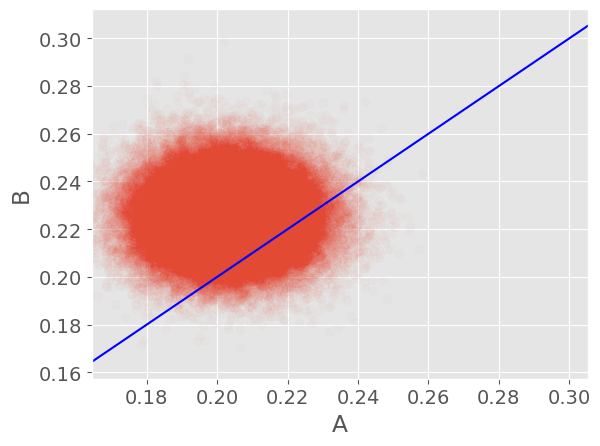

In [20]:
plt.scatter(simulated_A, simulated_B, alpha = .02);
plt.xlim(plt.ylim())
plt.xlabel('A'), plt.ylabel('B')
plt.plot(plt.xlim(), plt.xlim(), color = 'blue');

Translation: In our simulation, 89% of the time site B is better than site A. We can then interpret this as a probability, meaning we can say:

> "It is 89% likely that site B is better than site A."

**CAN FREQUENTIST DO THAT?** No, they can NOT!

### What's the 95% credible interval of site B's conversion rate?

In Bayesian testing, the credible interval is analogous to the confidence interval in the frequentist approach. 

To calculate it, we measure the area under the curve that contains 95% of the data, or rather the interval under the curve that does not contain the first or last 2.5% of the data. Note that the distribution may be skewed, so these aren't necessarily symmetrical around the distribution mean.

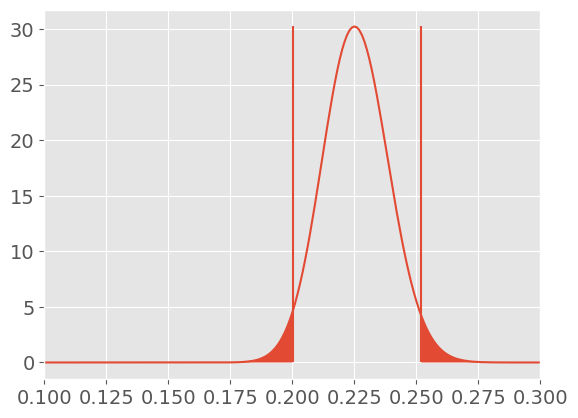

In [21]:
x = np.linspace(0,1,1001)
plt.plot(x, dist_B.pdf(x))
plt.vlines(dist_B.ppf([.025, .975]), ymin = 0, ymax = dist_B.pdf(x).max())
plt.xlim([0.1,.3])
plt.fill_between(x, 0, dist_B.pdf(x), where = (x< dist_B.ppf(.025)) | (x > dist_B.ppf(.975) ))

In [22]:
interval_size = 0.95
tail_area = (1 - interval_size) / 2

print("{0:0.1f}% credible interval conversion rate lower bound: {1:0.3f}, upper bound {2:0.3f}".format(
       interval_size *100,
       dist_B.ppf(tail_area), 
       dist_B.ppf(1 - tail_area)))

95.0% credible interval conversion rate lower bound: 0.200, upper bound 0.252


### What if the difference between sites A and B is larger?

Let's explore this.

In [23]:
x = np.load("samples.npz")

n = 1000

site_A_samples = x['site_A_samples'][:n]
site_C_samples = x['site_C_samples'][:n]

np.mean(site_A_samples), np.mean(site_C_samples)

(0.202, 0.315)

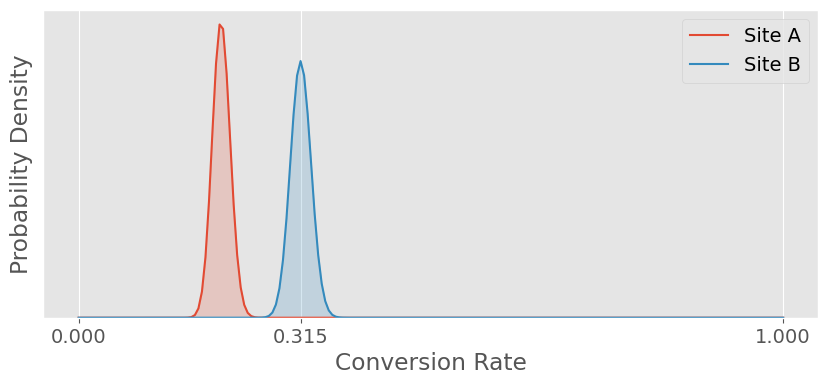

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plot_beta_website(site_A_samples, ax, label="Site A")
plot_beta_website(site_C_samples, ax, label="Site B")
ax.legend()

In [25]:
alpha, beta = get_beta_dist_params(site_A_samples)[:2]
dist_A = stats.beta(alpha, beta)

alpha, beta = get_beta_dist_params(site_C_samples)[:2]
dist_C = stats.beta(alpha, beta)

simulated_A = dist_A.rvs(num_simulations)
simulated_C = dist_C.rvs(num_simulations)
C_vs_A = simulated_C > simulated_A
print((simulated_C > simulated_A).mean())

1.0


In [26]:
C_vs_A.sum()

100000

In our simulation, 100% of the time site C is better than site A. We can then interpret this as a probability, meaning we can say:

> "It is 100% likely that site C is better than site A."

We used 1,000 samples of each site just now. We _probably_ didn't need this much data in this case; we probably spent longer running this test than needed. Re-run the three cells above using less data. (You really only need about 300 samples of each site with this amount of difference between the sites.)

### Benefits of Bayesian A/B Testing

In general, Bayesian A/B testing is better for these reason:

1. You can say stuff like "It is \_\_% likely that site \_\_ is better than site \_\_."
2. You can stop the test early based on surprising data.
3. You can update the test while it is running.

## Why do we call this Bayesian A/B Testing?

I haven't yet proved to you that what we did above is actually _correct_. All we've done is show that the Beta Distribution _seems_ to do what we want if we set $\alpha$ and $\beta$ to the number of conversions and failures, respectively. Let's work on showing _why_ this works.

We can derive it by beginning with Bayes' Theorem. First, let's just recall the theorem:

![](images/bayes_formula.png)

$\Theta$ represents the random variable that is our unknown conversion rate, and $y$ is the number of conversions we've observed on the website to-date.

Next, we note that the denominator on the right ($P(y)$) is just a normalizing term, so we'll simplify it to:

$$P(\Theta \, | \, y) \propto P(y \, | \, \Theta) P(\Theta)$$

In the past we've only put scalar values into each part of the equation above, but... what if we plugged PDF equations into each part? Let's try it.

Our prior ($P(\Theta)$) will be a uniform distribution initially, meaning we don't have any initial belief about what values $\Theta$ should be -- we see all values as equally likely (we don't _have_ to do it this way, but this will work fine).  We use the $\beta$ here, however, because it can give a uniform distribution initially but evolve as data comes in.

Our likelihood distribution ($P(y \, | \, \Theta)$) is a Binomial distribution. It will tell us the likelihood of our data under various values of $\Theta$. 

Finally, the posterior distribution ($P(\Theta \, | \, y)$) tells us what we actually want to know: the relative probability of each value of $\Theta$ (i.e. the relative probability of each possible conversion rate).

$$
\begin{align*}
P(\Theta \, | \, y) &\propto P(y \, | \, \Theta) * P(\Theta) \\
P(\Theta \, | \, y) &\propto \text{Binomial}(n, \Theta) * \text{Beta}(\alpha, \beta) \\
P(\Theta \, | \, y) &\propto {n \choose y} \Theta^y (1-\Theta)^{n-y} * \dfrac{\Theta^{\alpha - 1} (1-\Theta)^{\beta - 1}}{B(\alpha, \beta)} \\
P(\Theta \, | \, y) &\propto \Theta^y (1-\Theta)^{n-y} * \Theta^{\alpha - 1} (1-\Theta)^{\beta - 1} \\
P(\Theta \, | \, y) &\propto \Theta^{\alpha + y - 1} (1-\Theta)^{\beta + n - y - 1} \\
P(\Theta \, | \, y) &= \text{Beta}(\alpha' = \alpha + y, \, \, \beta' = \beta + n - y) \\
\end{align*}
$$

All that's to say, if you multiply a Beta distribution by a Binomial distribution, out pops a *new* Beta distribution:

$$\text{Beta} \propto \text{Binomial} * \text{Beta}$$

This relationship, where your prior and posterior are of the same distribution family, is called a "conjugate prior".  The Beta distribution is a "conjugate prior" of the binomial distribution. There are many more [conjugate prior relationships.](https://en.wikipedia.org/wiki/Conjugate_prior)

The derivation above shows that our process for modeling conversion rates on websites is sound. What's really going on is that we've found a short-cut way of applying Bayes' theorem to update our prior beliefs. We usually make our first prior just a uniform distribution by using a Beta distribution with $\alpha=1$ and $\beta=1$.

To recap, we model the conversion rate as a Beta distribution where:
- $\alpha = 1 + \text{number of conversions on our website}$
- $\beta = 1 + \text{number of misses on our website}$

This final plot shows how we can update our belief with more-and-more data to get stronger-and-stronger beliefs of the underlying conversion rate of our website.

In [27]:
x = np.load("samples.npz")

site_A_samples = x['site_A_samples']

len(site_A_samples), np.mean(site_A_samples)

(10000, 0.2055)

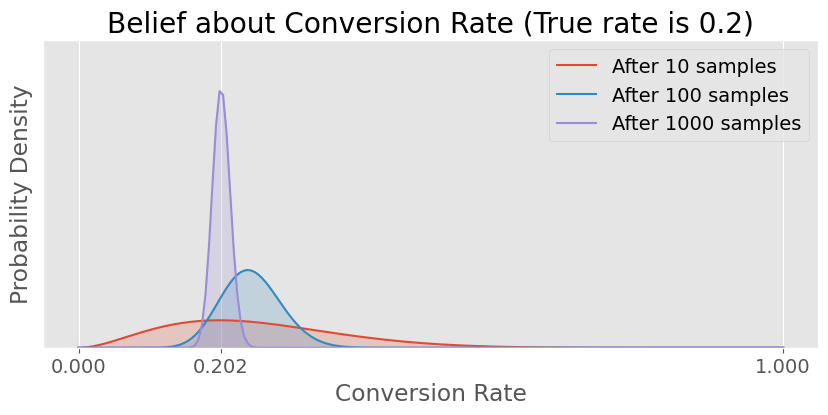

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

num_samples = [10, 100, 1000]  # , 10000

for k in num_samples:
    samples = site_A_samples[:k]
    plot_beta_website(samples, ax, label="After {} samples".format(k))

ax.set_title("Belief about Conversion Rate (True rate is 0.2)")
ax.legend();

## Final Words

Frequentist methods were created before modern computers. Those methods lean on limits and integrals which can be done by hand. It's from those limits and integrals that they have to take the "long run" point of view.

Bayesians still build on top of the laws of probability and the well-known distributions, but Bayesians take a different approach to how they interpret probability, which fits better with our needs (usually). Bayesians love to build layers of distributions one atop the other, using Bayes' theorem to string them all together. Once built, they  visualize the final distribution by repeated sampling, requiring a lot of computation (thank you, computers).

All scientists love data. We love data because it helps us understand the world. That's why we like the Bayesian mindset. We believe things, we collect data, and we refine our beliefs. Then we repeat that. I leave you with this final _xkcd_.

<img src="https://imgs.xkcd.com/comics/the_difference.png" width=500px>

**Revisit Objectives:**

- Compare and Contrast Frequentist vs Bayesian Mindsets
- Perform A/B Testing under a Bayesian Framework
- Explain what a conjugate prior is
- Show why Bayesian A/B Testing is _Bayesian_